In [18]:
import sys
sys.path.append("/home/jarlehti/projects/gradu")

In [25]:
import os
import glob
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
import dill
from src.napsu_mq.napsu_mq import NapsuMQResult
import numpy as np

In [3]:
CURRENT_FOLDER = os.path.dirname(os.path.dirname(os.path.abspath(__name__)))
LOG_FOLDER = os.path.join(CURRENT_FOLDER, "logs")
MODELS = os.path.join(CURRENT_FOLDER, "models")

In [5]:
inference_data_files = glob.glob(os.path.join(LOG_FOLDER, 'inf_data*'))

In [6]:
inf_data = az.from_netcdf(inference_data_files[8])

In [7]:
inf_data

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [12]:
for data in inference_data_files:
    inf_data = az.from_netcdf(data)
    print(az.summary(inf_data))

                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
norm_lambdas[0]  0.017  0.988  -1.973    1.757      0.009    0.011   12943.0   
norm_lambdas[1]  0.007  0.985  -1.798    1.870      0.008    0.011   13845.0   
norm_lambdas[2]  0.016  1.003  -1.872    1.849      0.009    0.012   11179.0   
norm_lambdas[3]  0.011  0.992  -1.847    1.838      0.009    0.011   12120.0   
norm_lambdas[4] -0.013  0.994  -1.837    1.865      0.009    0.011   11989.0   
norm_lambdas[5] -0.004  0.985  -1.745    1.932      0.009    0.011   11462.0   
norm_lambdas[6]  0.002  1.004  -1.829    1.892      0.009    0.011   13323.0   

                 ess_tail  r_hat  
norm_lambdas[0]    6192.0    1.0  
norm_lambdas[1]    6350.0    1.0  
norm_lambdas[2]    5953.0    1.0  
norm_lambdas[3]    6460.0    1.0  
norm_lambdas[4]    6403.0    1.0  
norm_lambdas[5]    6270.0    1.0  
norm_lambdas[6]    6410.0    1.0  
                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \

                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
norm_lambdas[0]  0.012  0.987  -1.790    1.918      0.008    0.011   13690.0   
norm_lambdas[1]  0.002  0.994  -1.878    1.833      0.009    0.012   13129.0   
norm_lambdas[2]  0.017  1.011  -1.855    1.949      0.009    0.012   12007.0   
norm_lambdas[3]  0.009  1.007  -1.854    1.886      0.009    0.012   11559.0   
norm_lambdas[4] -0.010  0.998  -1.854    1.874      0.009    0.011   13417.0   
norm_lambdas[5] -0.002  0.984  -1.791    1.903      0.009    0.012   12846.0   
norm_lambdas[6] -0.007  1.000  -1.803    1.905      0.009    0.011   13193.0   

                 ess_tail  r_hat  
norm_lambdas[0]    6344.0    1.0  
norm_lambdas[1]    6519.0    1.0  
norm_lambdas[2]    5883.0    1.0  
norm_lambdas[3]    5824.0    1.0  
norm_lambdas[4]    6194.0    1.0  
norm_lambdas[5]    6101.0    1.0  
norm_lambdas[6]    6318.0    1.0  
                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \

                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
norm_lambdas[0]  0.006  0.991  -1.846    1.858      0.009    0.012   13315.0   
norm_lambdas[1]  0.000  0.993  -1.884    1.833      0.009    0.011   12450.0   
norm_lambdas[2]  0.010  1.014  -1.939    1.841      0.009    0.012   11889.0   
norm_lambdas[3]  0.008  0.991  -1.848    1.869      0.009    0.011   11754.0   
norm_lambdas[4] -0.005  1.001  -1.811    1.875      0.009    0.012   11920.0   
norm_lambdas[5]  0.006  0.974  -1.845    1.810      0.009    0.011   12291.0   
norm_lambdas[6]  0.010  1.009  -1.867    1.879      0.009    0.011   13304.0   

                 ess_tail  r_hat  
norm_lambdas[0]    6125.0    1.0  
norm_lambdas[1]    6413.0    1.0  
norm_lambdas[2]    5696.0    1.0  
norm_lambdas[3]    6276.0    1.0  
norm_lambdas[4]    5922.0    1.0  
norm_lambdas[5]    6327.0    1.0  
norm_lambdas[6]    6069.0    1.0  
                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \

                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
norm_lambdas[0] -0.009  0.994  -1.863    1.820      0.009    0.012   12877.0   
norm_lambdas[1]  0.003  0.994  -1.846    1.873      0.009    0.011   13045.0   
norm_lambdas[2]  0.020  1.016  -1.923    1.837      0.009    0.012   12646.0   
norm_lambdas[3]  0.015  0.992  -1.811    1.873      0.009    0.012   11347.0   
norm_lambdas[4] -0.012  1.000  -1.847    1.898      0.009    0.011   11846.0   
norm_lambdas[5] -0.001  0.984  -1.830    1.856      0.009    0.011   12394.0   
norm_lambdas[6]  0.004  1.014  -1.892    1.879      0.009    0.012   13900.0   

                 ess_tail  r_hat  
norm_lambdas[0]    6022.0    1.0  
norm_lambdas[1]    6264.0    1.0  
norm_lambdas[2]    5897.0    1.0  
norm_lambdas[3]    5666.0    1.0  
norm_lambdas[4]    6024.0    1.0  
norm_lambdas[5]    6445.0    1.0  
norm_lambdas[6]    6449.0    1.0  
                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \

                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
norm_lambdas[0]  0.006  0.993  -1.842    1.852       0.01    0.011    9649.0   
norm_lambdas[1] -0.003  0.996  -1.858    1.866       0.01    0.011   10767.0   
norm_lambdas[2] -0.004  1.000  -1.882    1.891       0.01    0.011   10588.0   
norm_lambdas[3] -0.009  0.984  -1.914    1.781       0.01    0.011    9476.0   
norm_lambdas[4]  0.001  1.002  -2.020    1.743       0.01    0.011   10144.0   

                 ess_tail  r_hat  
norm_lambdas[0]    5878.0    1.0  
norm_lambdas[1]    6430.0    1.0  
norm_lambdas[2]    5947.0    1.0  
norm_lambdas[3]    5914.0    1.0  
norm_lambdas[4]    5899.0    1.0  
                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
norm_lambdas[0]  0.004  1.007  -1.882    1.871       0.01    0.011    9971.0   
norm_lambdas[1] -0.005  0.999  -1.836    1.892       0.01    0.012   10081.0   
norm_lambdas[2]  0.012  1.009  -1.942    1.868       0.01    0.011   

                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
norm_lambdas[0]  0.012  1.000  -1.887    1.893      0.008    0.011   14137.0   
norm_lambdas[1] -0.002  0.985  -1.751    1.935      0.009    0.012   13177.0   
norm_lambdas[2]  0.014  1.000  -1.912    1.816      0.009    0.012   12005.0   
norm_lambdas[3]  0.009  0.988  -1.834    1.845      0.009    0.011   12776.0   
norm_lambdas[4] -0.007  1.004  -1.864    1.878      0.009    0.012   13107.0   
norm_lambdas[5]  0.011  0.987  -1.758    1.932      0.009    0.012   12225.0   
norm_lambdas[6] -0.002  1.005  -1.887    1.854      0.008    0.012   14363.0   

                 ess_tail  r_hat  
norm_lambdas[0]    6381.0    1.0  
norm_lambdas[1]    5968.0    1.0  
norm_lambdas[2]    6364.0    1.0  
norm_lambdas[3]    6422.0    1.0  
norm_lambdas[4]    6167.0    1.0  
norm_lambdas[5]    5954.0    1.0  
norm_lambdas[6]    5448.0    1.0  
                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \

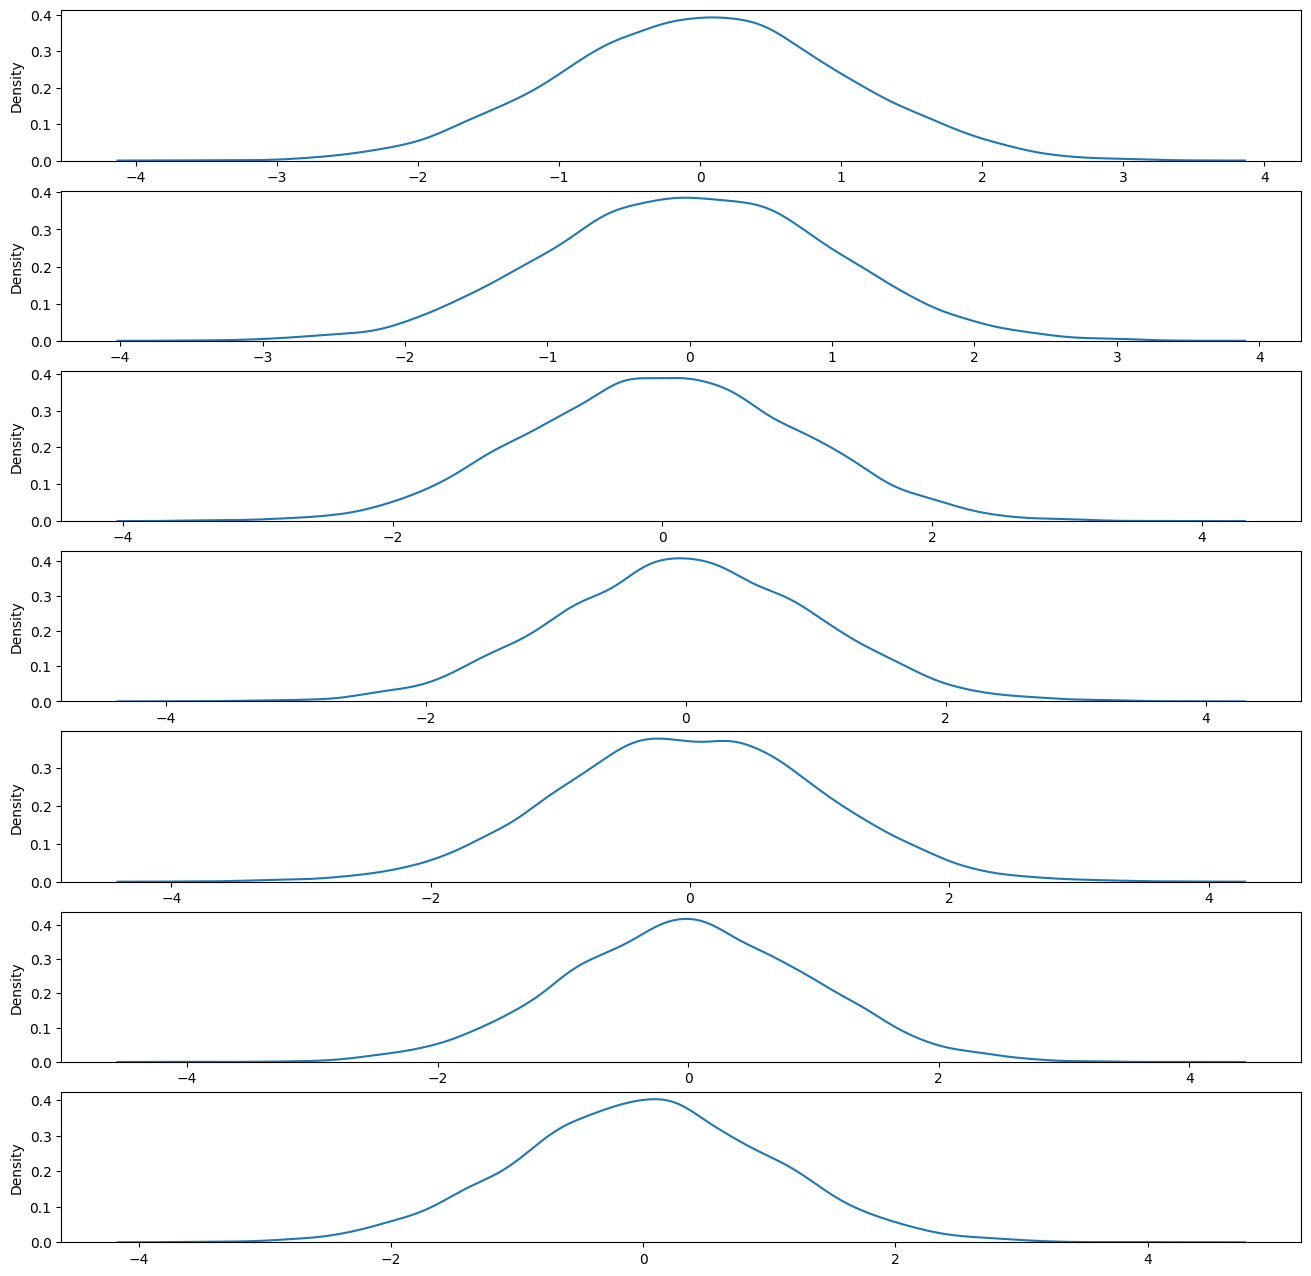

In [11]:
posterior_values = inf_data.posterior.stack(draws=("chain", "draw"))
posterior_values = posterior_values.norm_lambdas.values.transpose()

fig, ax = plt.subplots(7, figsize=(16, 16))

for i in range(7):
    sns.kdeplot(posterior_values[:, i], ax=ax[i], label="MCMC")

In [8]:
inference_data_files[8]

'/home/local/jarlehti/projects/gradu/logs/inf_data_binary4d_AC_30e_NUTS.nc'

In [22]:
model_path = os.path.join(MODELS, "napsu_binary4d_AC_30e_NUTS.dill")
model_binary = open(model_path, "rb")
model = NapsuMQResult.load(model_binary)

In [27]:
posterior_values_orig = np.array(model.posterior_values)

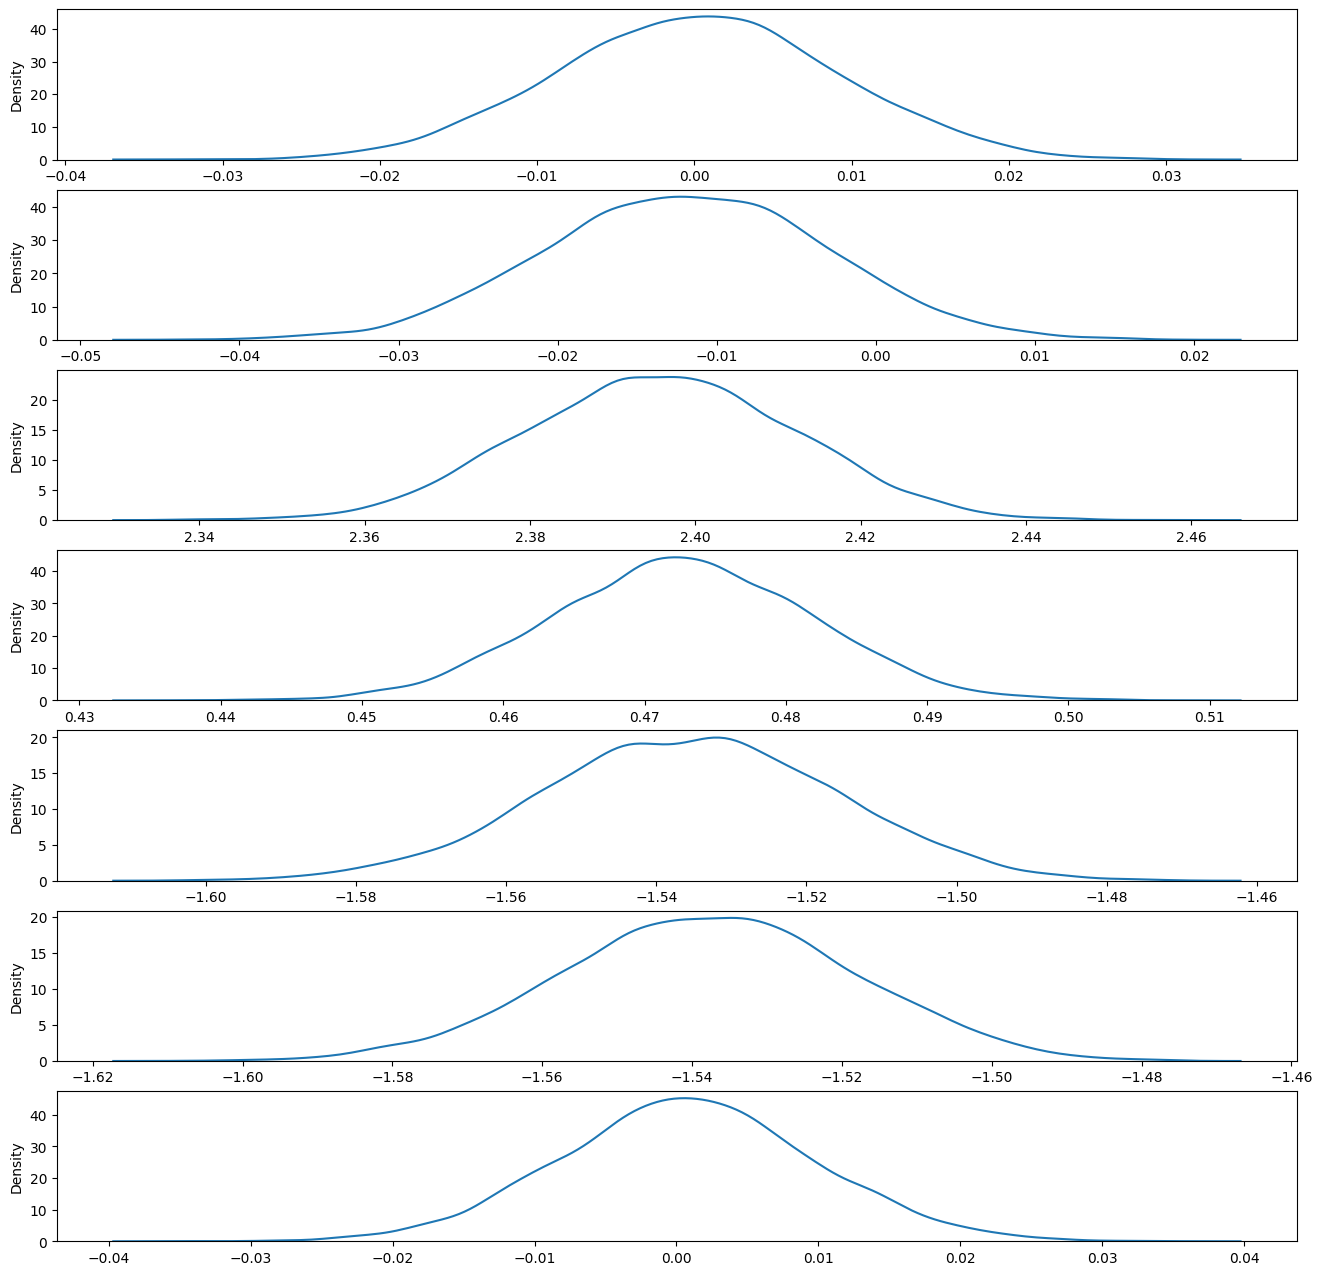

In [31]:
fig, ax = plt.subplots(7, figsize=(16, 16))

for i in range(7):
    sns.kdeplot(posterior_values_orig[:, i], ax=ax[i], label="MCMC")